# We have a regression... but need to convert it some-how

**There can me multiple approaches to deal with this conversion**.

- The setup is the similar.
- But this time, instead of having a single node in the output layer, we will have `n` nodes per class.
- That will make, `n` linear models.

**Read the passage below:**

In general, classification problems do not come
with natural orderings among the classes.
Fortunately, statisticians long ago invented a simple way
to represent categorical data: the *one-hot encoding*.
A one-hot encoding is a vector
with as many components as we have categories.
The component corresponding to a particular instance's category is set to 1
and all other components are set to 0.
In our case, a label $y$ would be a three-dimensional vector,
with $(1, 0, 0)$ corresponding to "cat", $(0, 1, 0)$ to "chicken",
and $(0, 0, 1)$ to "dog":

$$y \in \{(1, 0, 0), (0, 1, 0), (0, 0, 1)\}.$$

### Linear Model

In order to estimate the conditional probabilities
associated with all the possible classes,
we need a model with multiple outputs, one per class.
To address classification with linear models,
we will need as many affine functions as we have outputs.
Strictly speaking, we only need one fewer,
since the final category has to be the difference
between $1$ and the sum of the other categories,
but for reasons of symmetry
we use a slightly redundant parametrization.
Each output corresponds to its own affine function.
In our case, since we have 4 features and 3 possible output categories,
we need 12 scalars to represent the weights ($w$ with subscripts),
and 3 scalars to represent the biases ($b$ with subscripts). This yields:

$$
\begin{aligned}
o_1 &= x_1 w_{11} + x_2 w_{12} + x_3 w_{13} + x_4 w_{14} + b_1,\\
o_2 &= x_1 w_{21} + x_2 w_{22} + x_3 w_{23} + x_4 w_{24} + b_2,\\
o_3 &= x_1 w_{31} + x_2 w_{32} + x_3 w_{33} + x_4 w_{34} + b_3.
\end{aligned}
$$

The corresponding neural network diagram
is shown in :numref:`fig_softmaxreg`.
Just as in linear regression,
we use a single-layer neural network.
And since the calculation of each output, $o_1, o_2$, and $o_3$,
depends on every input, $x_1$, $x_2$, $x_3$, and $x_4$,
the output layer can also be described as a *fully connected layer*.

![Softmax regression is a single-layer neural network.](../images/softmaxreg.svg)


## And the ways to do this are...


There are many ways we might accomplish this goal.

1. For instance, we could assume that the outputs
$\mathbf{o}$ are corrupted versions of $\mathbf{y}$,
where the corruption occurs by means of adding noise $\boldsymbol{\epsilon}$
drawn from a normal distribution.
In other words, $\mathbf{y} = \mathbf{o} + \boldsymbol{\epsilon}$,
where $\epsilon_i \sim \mathcal{N}(0, \sigma^2)$.
This is the so-called [probit model](https://en.wikipedia.org/wiki/Probit_model),
first introduced by :citet:`Fechner.1860`.
While appealing, it does not work quite as well
nor lead to a particularly nice optimization problem,
when compared to the softmax.

2. Another way to accomplish this goal
(and to ensure nonnegativity) is to use
an exponential function $P(y = i) \propto \exp o_i$.
This does indeed satisfy the requirement
that the conditional class probability
increases with increasing $o_i$, it is monotonic,
and all probabilities are nonnegative.
We can then transform these values so that they add up to $1$
by dividing each by their sum.
This process is called *normalization*.
Putting these two pieces together
gives us the *softmax* function:

$$\hat{\mathbf{y}} = \mathrm{softmax}(\mathbf{o}) \quad \textrm{where}\quad \hat{y}_i = \frac{\exp(o_i)}{\sum_j \exp(o_j)}.$$

Note that the largest coordinate of $\mathbf{o}$
corresponds to the most likely class according to $\hat{\mathbf{y}}$.
Moreover, because the softmax operation
preserves the ordering among its arguments,
we do not need to compute the softmax
to determine which class has been assigned the highest probability. Thus,

$$
\operatorname*{argmax}_j \hat y_j = \operatorname*{argmax}_j o_j.
$$


## 1️⃣ We are interested in exploring the first one.

In [1]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

# Generate some example data
np.random.seed(0)
N = 100  # number of data points
X = np.random.normal(loc=50, scale=15, size=N)  # income values (features)


In [2]:
X

array([76.46078519, 56.00235813, 64.68106976, 83.61339799, 78.01336985,
       35.3408318 , 64.25132626, 47.72964188, 48.45171722, 56.15897753,
       52.16065357, 71.8141026 , 61.41556588, 51.82512525, 56.65794849,
       55.00511491, 72.4111861 , 46.92262604, 54.69601552, 37.18856391,
       11.70515276, 59.80427893, 62.96654298, 38.86752469, 84.04631936,
       28.18451488, 50.68637776, 47.19224225, 72.99168822, 72.04038155,
       52.32421139, 55.67243779, 36.68321379, 20.28805298, 44.78131776,
       52.34523454, 68.45436021, 68.03569773, 44.19009774, 45.46545874,
       34.27170552, 28.69973094, 24.40594714, 79.26163093, 42.35521727,
       43.42888548, 31.2080696 , 61.66235534, 25.79153229, 46.8088958 ,
       36.56800158, 55.80353747, 42.33792294, 32.29051724, 49.57726657,
       56.42497806, 50.99775834, 54.53707847, 40.48516859, 44.55888251,
       39.91309328, 44.60670258, 37.80280577, 24.10576097, 52.66139213,
       43.97328596, 25.5470248 , 56.94173383, 36.39052453, 50.77

In [3]:
# True parameters (unknown in practice)
w_true = 0.05  # weight for the income feature
b_true = -2    # bias term

In [4]:
# Linear combination (o = wX + b)
o = w_true * X + b_true

In [5]:
# just some values...
o

array([ 1.82303926,  0.80011791,  1.23405349,  2.1806699 ,  1.90066849,
       -0.23295841,  1.21256631,  0.38648209,  0.42258586,  0.80794888,
        0.60803268,  1.59070513,  1.07077829,  0.59125626,  0.83289742,
        0.75025575,  1.6205593 ,  0.3461313 ,  0.73480078, -0.1405718 ,
       -1.41474236,  0.99021395,  1.14832715, -0.05662377,  2.20231597,
       -0.59077426,  0.53431889,  0.35961211,  1.64958441,  1.60201908,
        0.61621057,  0.78362189, -0.16583931, -0.98559735,  0.23906589,
        0.61726173,  1.42271801,  1.40178489,  0.20950489,  0.27327294,
       -0.28641472, -0.56501345, -0.77970264,  1.96308155,  0.11776086,
        0.17144427, -0.43959652,  1.08311777, -0.71042339,  0.34044479,
       -0.17159992,  0.79017687,  0.11689615, -0.38547414,  0.47886333,
        0.8212489 ,  0.54988792,  0.72685392,  0.02425843,  0.22794413,
       -0.00434534,  0.23033513, -0.10985971, -0.79471195,  0.63306961,
        0.1986643 , -0.72264876,  0.84708669, -0.18047377,  0.53

In [6]:

# Convert o to probabilities using the CDF of the normal distribution
probs = stats.norm.cdf(o)

In [7]:
probs

array([0.96585128, 0.78817876, 0.89140851, 0.98539608, 0.97132728,
       0.40789685, 0.88735216, 0.65043017, 0.66370128, 0.79043999,
       0.7284171 , 0.94416202, 0.85786544, 0.72282563, 0.79754871,
       0.77344965, 0.94744391, 0.63537798, 0.76876958, 0.44410411,
       0.07857202, 0.83896522, 0.87458323, 0.47742245, 0.9861785 ,
       0.27733584, 0.70343954, 0.64043139, 0.95048602, 0.9454243 ,
       0.73112222, 0.783369  , 0.4341417 , 0.16216537, 0.59447275,
       0.73146895, 0.92259104, 0.91951025, 0.58297294, 0.60767829,
       0.38728025, 0.28603231, 0.21778296, 0.97518165, 0.54687143,
       0.56806278, 0.33011468, 0.86062192, 0.23872081, 0.6332392 ,
       0.43187603, 0.78528776, 0.54652882, 0.34994308, 0.68398207,
       0.79424775, 0.70880187, 0.76634228, 0.50967676, 0.59015516,
       0.49826647, 0.59108432, 0.45626032, 0.21339054, 0.73665591,
       0.57873732, 0.23494785, 0.8015266 , 0.42839032, 0.70504244,
       0.85240822, 0.72465857, 0.9122196 , 0.33501043, 0.78865

In [17]:
# Simulate binary outcomes (y = 1 with probability = prob, else y = 0)
y = np.random.binomial(1, probs)

In [18]:
y

array([1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1,
       1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1,
       0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1])

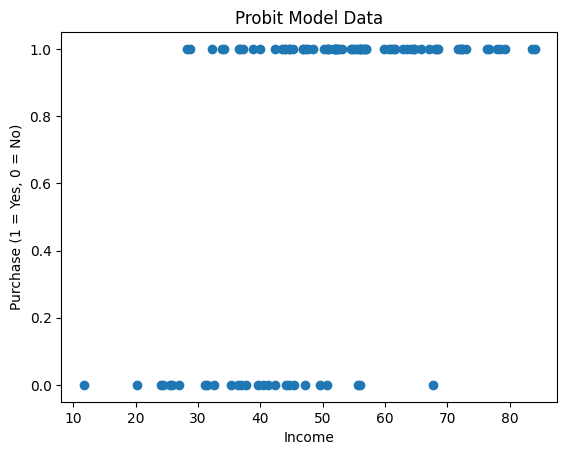

In [10]:
# Visualize the data
plt.scatter(X, y, label='True outcomes')
plt.xlabel('Income')
plt.ylabel('Purchase (1 = Yes, 0 = No)')
plt.title('Probit Model Data')
plt.show()

# 

In [34]:
probs = np.array([.1, .4, .4, .1])

In [35]:
probs.sum()

1.0

In [37]:
np.log(probs.prod())

-6.437751649736401

In [39]:
np.log(probs).sum()

-6.4377516497364

So this is how it works.

- We **need** to multiply the probs
- But that will lead to too small values causing undderflow or overflow situation
- So we take logs
- Then we add the logged probabilitites that will do the same thing.

## What happens in a nutshell


$$
P(\mathbf{Y} \mid \mathbf{X}) = \prod_{i=1}^n P(\mathbf{y}^{(i)} \mid \mathbf{x}^{(i)}).
$$


This function is the **actual loss function**.

- Here, we will get the probabilities for all classes.
- For example if you are predicting, `cat, dog or bull` then let's say for the first record your **actual** was cat then you will pick the **probability on the first index**.
- It will be generally wrong, so let's say it is `0.2` for cat.
- You will do this for **all records**
- Mutiply them and that is your loss.

Here we take the log, so **the lower the number is, the higher the log is**

In [2]:
# example
np.log(0.2) # prob of being a cat

-1.6094379124341003

In [3]:
np.log(0.9) # prob of being a cat

-0.10536051565782628

🎉 That's how it works!!